<a href="https://colab.research.google.com/github/tranhuuan1703/Application-Faster-RCNN-model-to-cervical-cancer-cells-detection/blob/main/Model_deployment_7_6_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Khởi tạo và cài đặt các thư viện

In [ ]:
! pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
import json
import cv2
import numpy as np

#IMPORTS
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import random

import skimage.draw
import tifffile
import os
import shutil

from PIL import Image
import torch
from torchvision import datasets
from torch.utils.data import Dataset ,DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn
import numpy as np
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp

from torchvision import transforms

In [ ]:
# load model
def load_model(path_model):
  ENCODER = 'resnet50'
  ENCODER_WEIGHTS = 'imagenet'


  ACTIVATION = None
  model = smp.Unet(
      encoder_name=ENCODER,
      encoder_weights=ENCODER_WEIGHTS,
      in_channels=1,
      classes=1,
      activation=ACTIVATION,
  )

  model.load_state_dict(torch.load(path_model))
  return model

def load_img(path_imag):
  img = Image.open(path_imag)
  image_gray = img.convert("L")
  return image_gray

# Define transformations
image_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
    transforms.Lambda(lambda x: x.clamp(0, 1))
])


# model predicting
def model_predict(model, img):

  with torch.inference_mode():
    # img = img.transpose(2, 0, 1)
    img_tensor = img.unsqueeze(0)
    mask_predict = model(img_tensor)
    y_pred_binary = (mask_predict > 0.5).float()
  return y_pred_binary


def draw_mask(image, mask_generated) :
  masked_image = image.copy()


  masked_image = mask_generated.astype(np.uint8)

  return cv2.addWeighted(image, 0.3, mask_generated, 0.7, 0)

In [ ]:
paths = ['/content/drive/MyDrive/Segmentation/segmentation_brain_data/valid2/images/1001_jpg.rf.a64df329f81626672c9b81f95d421c84.jpg',
         '/content/drive/MyDrive/Segmentation/segmentation_brain_data/valid2/images/1576_jpg.rf.741699ed98cd032116b2975fecf738f8.jpg',
         '/content/drive/MyDrive/Segmentation/segmentation_brain_data/valid2/images/2091_jpg.rf.95766b99e2df6f8be58721e6988324c3.jpg'
         ]
model_path_unet = '/content/drive/MyDrive/Segmentation/your_model_u_net.pt'
model = load_model(model_path_unet)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 102MB/s]


In [ ]:

def predict(path):
  imgs = cv2.imread(path)
  imgs = cv2.resize(imgs, (224, 224))
  img = load_img(paths[0])
  img = image_transform(img)
  y_pred_binary = model_predict(model, img)
  y_pred_binary = y_pred_binary.squeeze().numpy()
  img = img.numpy()[0, :, :]
  result = draw_mask(img, y_pred_binary)
  return result

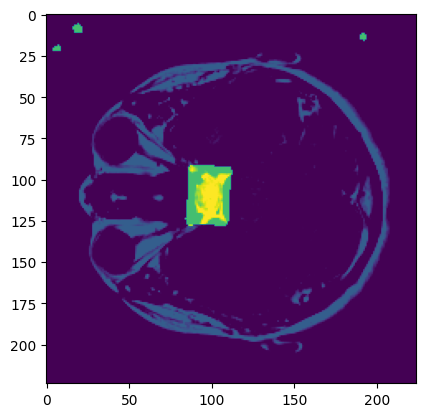

In [ ]:
result_img = predict(paths[0])
plt.imshow(result_img)

# deployment with fastAPI

In [ ]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [ ]:
app = FastAPI(title='Deploying a ML Model with FastAPI')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


# By using @app.get("/") you are allowing the GET method to work for the / endpoint.
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected. Now head over to http://localhost:8000/docs."



In [ ]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# Host depends on the setup you selected (docker or virtual env)
host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"

# Spin up the server!
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [1126]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13622: RuntimeWarning: coroutine 'Server.serve' was never awaited
  self.source = Source(update_ids_from_dap=update_ids_from_dap, **source) if source.__class__ !=  Source else source
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [1126]


KeyboardInterrupt: 